My plan is to create a bot that parses the 10 last major news articles for a given keyword in order to generate a summary of each article in a few seconds followed by a sentiment analysis.

This is informative and useful to anyone as a trader/investor when considering recent stocks or crypto news!

You can also use it for fun or out of curiosity for any given keyword of your interest!

The flow of the bot:
1_Extract => 2_Summarize => 3_Analyze

1_We extract the articles from Google news with the Google News python package.
2_We summarize each article using Newspaper Python Package
3_Run sentiment analysis on each summary with the help of VADER.

In [1]:
!pip install GoogleNews
!pip install nltk
!pip install newspaper3k
!pip install wordcloud

You should consider upgrading via the 'c:\Users\Fluffy\AppData\Local\Programs\PythonCodingPack\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\Fluffy\AppData\Local\Programs\PythonCodingPack\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\Fluffy\AppData\Local\Programs\PythonCodingPack\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\Fluffy\AppData\Local\Programs\PythonCodingPack\python.exe -m pip install --upgrade pip' command.


In [2]:
#Importing Libraries

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import nltk

#Required for Sentiment Analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Fluffy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

News Extraction.

In [3]:
now = dt.date.today()
now = now.strftime('%m-%d-%Y')

yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'

config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fluffy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Keep in mind that the Google News package fetches only the 10 most recent news, this is important for our analysis to be timely & relevant.

In [4]:
keyword_interest = input("Please provide the name of the asset, stock or crypto of interest")
if keyword_interest != '':
    print(f'Extracting & Analyzing {keyword_interest}, it takes sometime!')
googlenews = GoogleNews(start = yesterday, end = now)
googlenews.search(keyword_interest)
result = googlenews.result()

#Storing Results in a pd DataFrame
df = pd.DataFrame(result)
print(df)

Extracting & Analyzing Tether, it takes sometime!
                                               title  \
0  Investors withdraw over $7 billion from tether...   
1  Now, it’s tether taking a hit: The world’s big...   
2  Stablecoin Giant Tether Loses Ground to Rival ...   
3  After LUNA and UST – Will Tether Stablecoin Be...   
4  Crypto: Stablecoin storm spreads after billion...   
5  Crash in Stablecoins: Tether Loses $7 Billion ...   
6              Tether suffers $7bn investor sell-off   
7  Tether Price Prediction: Is the USDT Stablecoi...   
8  Why one hedge-fund manager invests in Bank of ...   
9  Space Tether Could Prevent Dead Satellites fro...   

                               media         date                   datetime  \
0                               CNBC    1 day ago 2022-05-17 11:05:07.825475   
1                           Protocol  2 hours ago 2022-05-18 09:05:07.831621   
2                      BNN Bloomberg   7 mins ago                        NaT   
3            

Article Summarization

In [10]:
try:
    list = []
    for i in df.index:
        #Empty dictionary to append each article in each iteration
        dict = {}
        article = Article(df['link'][i], config = config)
        try:
            article.download()
            article.parse()
            article.nlp()
        except:
            pass
        dict['Date'] = df['date'][i]
        dict['Media'] = df['media'][i]
        dict['Title'] = article.title
        dict['Article'] = article.text
        dict['Summary'] = article.summary
        dict['Key_words'] = article.keywords
        list.append(dict)
    check_empty = not any(list)

    if check_empty == False:
        news_DF = pd.DataFrame(list)
        print(news_DF)

except Exception as e:
    print("There is an exception:"+ str(e))
    print("There are some issues in retrieving the date. Try again or enter a different keyword of interest!")

          Date                              Media  \
0    1 day ago                               CNBC   
1  2 hours ago                           Protocol   
2   0 mins ago                      BNN Bloomberg   
3  4 hours ago               Business 2 Community   
4    1 day ago                         Yahoo News   
5  5 hours ago               Investing.com Canada   
6    1 day ago                    Investment Week   
7    1 day ago                     Bankless Times   
8  3 hours ago  Manufacturing Business Technology   
9    1 day ago                         PYMNTS.com   

                                               Title  \
0  Investors withdraw over $7 billion from tether...   
1                   Tether lost $7 billion this week   
2  Stablecoin Giant Tether Loses Ground to Rival ...   
3                                                      
4  Crypto: Stablecoin storm spreads after billion...   
5  Crash in Stablecoins: Tether Loses $7 Billion ...   
6  Tremors through stabl

Sentiment Analysis of each summary

Positive Sentiment 4.00
Neutral Sentiment 1.00
Negative Sentiment 5.00


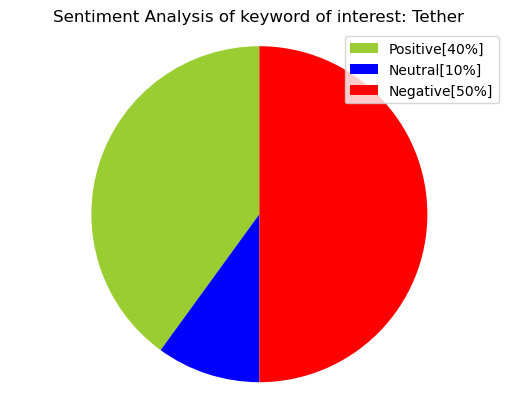

In [14]:
# news_df = news_df
def sentiment_percentage(part, whole):
    return 100 * float(part)/ float(whole)

#Initial values
positive = 0
negative = 0
neutral = 0

#Empty lists:

list_news = []
list_neutral = []
list_negative = []
list_positive = []

#Iterating throught the news in our dataframe 
for news in news_DF['Summary']:
    list_news.append(news)
    analyzer = SentimentIntensityAnalyzer().polarity_scores(news)
    nega = analyzer['neg']
    neut = analyzer['neu']
    posi = analyzer['pos']
    comp = analyzer['compound']

    if nega > posi:
        list_negative.append(news)
        negative += 1
    elif posi > nega:
        list_positive.append(news)
        positive += 1
    elif posi == nega:
        list_neutral.append(news)
        neutral += 1
positive = sentiment_percentage(positive, len(news_DF))
negative = sentiment_percentage(negative, len(news_DF))
neutral = sentiment_percentage(neutral, len(news_DF))

print("Positive Sentiment", "%.2f" % len(list_positive), end = '\n')
print("Neutral Sentiment", '%.2f' %len(list_neutral), end = '\n')
print("Negative Sentiment", "%.2f" %len(list_negative), end = '\n')

#PieChart

labels = ['Positive['+str(round(positive)) + '%]', 'Neutral['+str(round(neutral)) + '%]', 'Negative['+str(round(negative)) + '%]']
sizes = [positive, neutral, negative]
colorts = ['yellowgreen', 'blue', 'red']

patches, texts = plt.pie(sizes, colors = colors, startangle = 90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis of keyword of interest: " +keyword_interest+"")
plt.axis('equal')
plt.show()

Word Cloud Visualization    

WordCloud for Tether


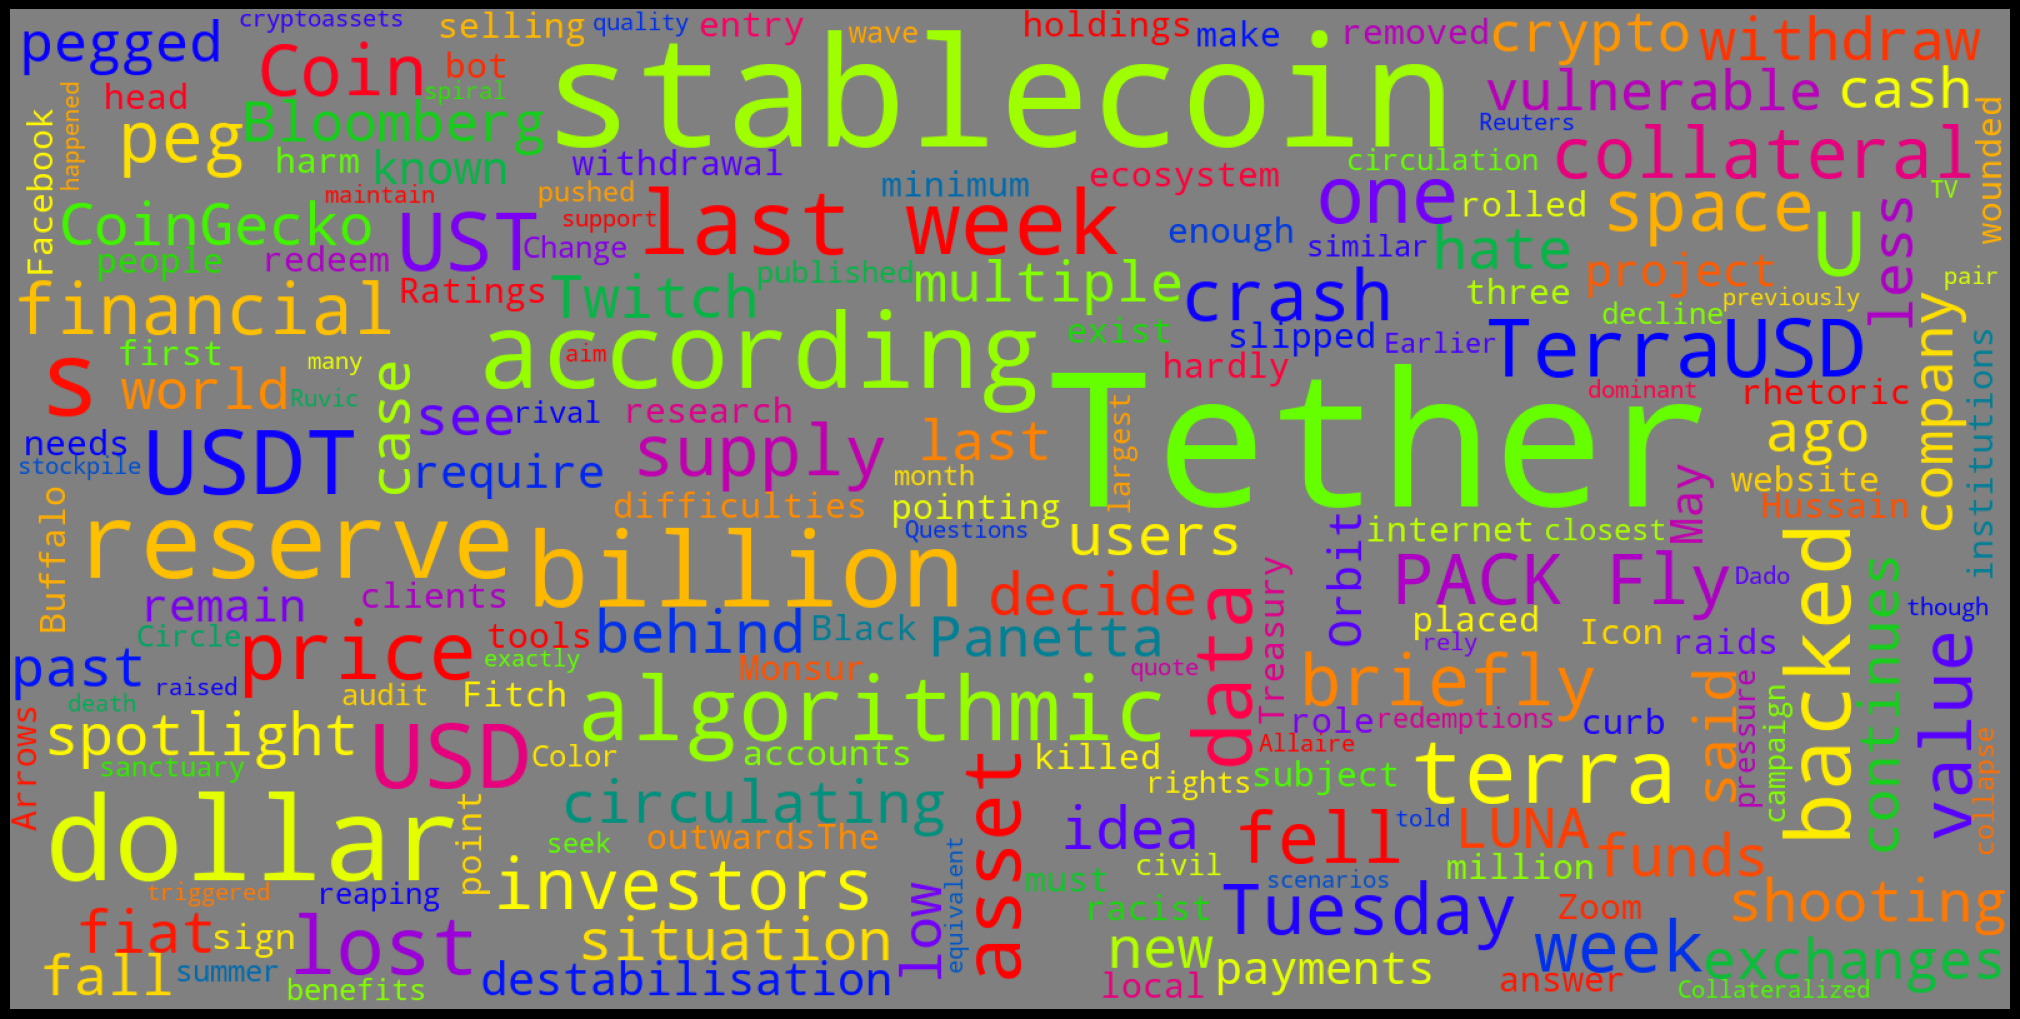

In [16]:
def cloud_words(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color = 'grey', width = 1600, height = 800, stopwords = stopwords, min_font_size= 18, max_font_size= 150, colormap= 'prism').generate(allWords)

    fig, ax = plt.subplots(figsize = (20,10), facecolor = 'k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad = 0)
    plt.show()

print('WordCloud for ' + keyword_interest)
cloud_words(news_DF['Summary'].values)